# Facial Expression Recognition from the idea of MobileNetV2

configurations

In [1]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import cv2 as cv
import numpy as np
import pickle
import sys
import time
import random
from tqdm import tqdm

check runtime environment

In [2]:
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 11, 8)
PyTorch version: 2.2.0+cu118
Device: cuda


## Prepare dataset
change the root for own dataset
custommize data augmentation

In [3]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
     transforms.RandomHorizontalFlip(0.5), #data augmentation
     transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.8, 1.2)),
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.5380, 0.4320, 0.3823), (0.2929, 0.2657, 0.2617))
     ]) # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.5380, 0.4320, 0.3823), (0.2929, 0.2657, 0.2617))
     ]) # Normalize the image data


train_set = torchvision.datasets.ImageFolder(root='./dataset/train', transform=train_transform)


test_set = torchvision.datasets.ImageFolder(root='./dataset/test', transform=test_transform)

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# Define the classes for the CIFAR-10 dataset
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


calculate the mean and s.d of training set (for normalization)(optional)

In [ ]:
# mean = 0.0
# for images, _ in train_loader:
#     batch_samples = images.size(0) 
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
# mean = mean / len(train_loader.dataset)

# var = 0.0
# for images, _ in train_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     var += ((images - mean.unsqueeze(1))**2).sum([0,2])
# std = torch.sqrt(var / (len(train_loader.dataset)*96*96))
# print(mean)
# print(std)

## Define inverted residual block structure

In [4]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

## Build Model Structure

In [5]:
# Define the CNN Model

class MobileNetv2_modify(nn.Module):
    def __init__(self):
        super(MobileNetv2_modify, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True)
            )
        self.invertedres1 = InvertedResidual(64,128,2,1)
        self.invertedres2 = InvertedResidual(128,128,1,6)
        self.invertedres3 = InvertedResidual(128,256,2,6)
        self.invertedres4 = InvertedResidual(256,256,1,6)
        self.invertedres5 = InvertedResidual(256,512,2,6)
        self.invertedres6 = InvertedResidual(512,512,1,6)
        self.invertedres7 = InvertedResidual(512,1024,2,6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1),
            nn.BatchNorm2d(2048),
            nn.ReLU6(inplace=True),
            nn.AvgPool2d(6)
            )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(2048, 8)
            )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.invertedres1(x)
        x = self.invertedres2(x)
        x = self.invertedres3(x)
        x = self.invertedres4(x)
        x = self.invertedres5(x)
        x = self.invertedres6(x)
        x = self.invertedres7(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

model = MobileNetv2_modify()

summary(model=model, input_size=(1, 3, 96, 96), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
MobileNetv2_modify (MobileNetv2_modify)  [1, 3, 96, 96]  [1, 8]          --              True
├─Sequential (conv1)                     [1, 3, 96, 96]  [1, 32, 96, 96] --              True
│    └─Conv2d (0)                        [1, 3, 96, 96]  [1, 32, 96, 96] 896             True
│    └─BatchNorm2d (1)                   [1, 32, 96, 96] [1, 32, 96, 96] 64              True
│    └─ReLU6 (2)                         [1, 32, 96, 96] [1, 32, 96, 96] --              --
├─Sequential (conv2)                     [1, 32, 96, 96] [1, 64, 96, 96] --              True
│    └─Conv2d (0)                        [1, 32, 96, 96] [1, 64, 96, 96] 18,496          True
│    └─BatchNorm2d (1)                   [1, 64, 96, 96] [1, 64, 96, 96] 128             True
│    └─ReLU6 (2)                         [1, 64, 96, 96] [1, 64, 96, 96] --              --
├─InvertedResidual (invertedres1)        [1, 64, 96, 96] [1

In [6]:
# Create a Models folder to store the checkpoints
!mkdir Model_y

A subdirectory or file Model_y already exists.


## Define loss function and optimizer

In [7]:
# Specify Loss/Cost function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify Learning Rate Scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

## Training

In [8]:
num_epochs = 100

# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Initialize the progress bar
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update the progress bar
        train_bar.set_postfix(loss=(train_loss / total_predictions), accuracy=(correct_predictions / total_predictions))

    # Calculate and store train loss and accuracy
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_acc = correct_predictions / total_predictions
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_val = 0
    total_val = 0

    # No need to track gradients for validation
    with torch.no_grad(), tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]') as test_bar:
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            # Update the progress bar
            test_bar.set_postfix(loss=(test_loss / total_val), accuracy=(correct_val / total_val))

    # Calculate and store validation loss and accuracy
    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc = correct_val / total_val
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    model.train()
    with open("Model_y/FER_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    # Print epoch stats
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')





Epoch 1/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.05it/s, accuracy=0.347, loss=1.57] 


Epoch 1/100, Train Loss: 1.7625, Train Accuracy: 0.2817, Test Loss: 1.5750, Test Accuracy: 0.3470


Epoch 2/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.435, loss=1.4] 


Epoch 2/100, Train Loss: 1.4506, Train Accuracy: 0.4106, Test Loss: 1.4016, Test Accuracy: 0.4351


Epoch 3/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.483, loss=1.31]


Epoch 3/100, Train Loss: 1.3089, Train Accuracy: 0.4805, Test Loss: 1.3117, Test Accuracy: 0.4825


Epoch 4/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.508, loss=1.28]


Epoch 4/100, Train Loss: 1.2138, Train Accuracy: 0.5260, Test Loss: 1.2804, Test Accuracy: 0.5080


Epoch 5/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.542, loss=1.19]


Epoch 5/100, Train Loss: 1.1558, Train Accuracy: 0.5466, Test Loss: 1.1923, Test Accuracy: 0.5421


Epoch 6/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.556, loss=1.17] 


Epoch 6/100, Train Loss: 1.1229, Train Accuracy: 0.5638, Test Loss: 1.1657, Test Accuracy: 0.5562


Epoch 7/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.541, loss=1.16]


Epoch 7/100, Train Loss: 1.0968, Train Accuracy: 0.5745, Test Loss: 1.1646, Test Accuracy: 0.5405


Epoch 8/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.16it/s, accuracy=0.555, loss=1.15]


Epoch 8/100, Train Loss: 1.0690, Train Accuracy: 0.5872, Test Loss: 1.1513, Test Accuracy: 0.5550


Epoch 9/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.18it/s, accuracy=0.579, loss=1.11] 


Epoch 9/100, Train Loss: 1.0486, Train Accuracy: 0.5965, Test Loss: 1.1128, Test Accuracy: 0.5794


Epoch 10/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.16it/s, accuracy=0.562, loss=1.17]


Epoch 10/100, Train Loss: 1.0422, Train Accuracy: 0.6002, Test Loss: 1.1667, Test Accuracy: 0.5617


Epoch 11/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.98it/s, accuracy=0.573, loss=1.12]


Epoch 11/100, Train Loss: 1.0216, Train Accuracy: 0.6116, Test Loss: 1.1177, Test Accuracy: 0.5727


Epoch 12/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.08it/s, accuracy=0.57, loss=1.14] 


Epoch 12/100, Train Loss: 1.0077, Train Accuracy: 0.6164, Test Loss: 1.1421, Test Accuracy: 0.5696


Epoch 13/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.16it/s, accuracy=0.598, loss=1.05] 


Epoch 13/100, Train Loss: 1.0013, Train Accuracy: 0.6196, Test Loss: 1.0462, Test Accuracy: 0.5978


Epoch 14/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.21it/s, accuracy=0.602, loss=1.05]


Epoch 14/100, Train Loss: 0.9879, Train Accuracy: 0.6244, Test Loss: 1.0545, Test Accuracy: 0.6021


Epoch 15/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.01it/s, accuracy=0.624, loss=1.02] 


Epoch 15/100, Train Loss: 0.9778, Train Accuracy: 0.6300, Test Loss: 1.0205, Test Accuracy: 0.6243


Epoch 16/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.05it/s, accuracy=0.596, loss=1.1]  


Epoch 16/100, Train Loss: 0.9706, Train Accuracy: 0.6364, Test Loss: 1.1010, Test Accuracy: 0.5959


Epoch 17/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.62, loss=0.996] 


Epoch 17/100, Train Loss: 0.9659, Train Accuracy: 0.6388, Test Loss: 0.9965, Test Accuracy: 0.6202


Epoch 18/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.04it/s, accuracy=0.547, loss=1.21]


Epoch 18/100, Train Loss: 0.9569, Train Accuracy: 0.6389, Test Loss: 1.2114, Test Accuracy: 0.5470


Epoch 19/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.577, loss=1.14] 


Epoch 19/100, Train Loss: 0.9509, Train Accuracy: 0.6444, Test Loss: 1.1422, Test Accuracy: 0.5773


Epoch 20/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.15it/s, accuracy=0.574, loss=1.14]


Epoch 20/100, Train Loss: 0.9472, Train Accuracy: 0.6417, Test Loss: 1.1418, Test Accuracy: 0.5741


Epoch 21/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.636, loss=0.956]


Epoch 21/100, Train Loss: 0.9445, Train Accuracy: 0.6454, Test Loss: 0.9560, Test Accuracy: 0.6360


Epoch 22/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.16it/s, accuracy=0.634, loss=1.01]


Epoch 22/100, Train Loss: 0.9381, Train Accuracy: 0.6506, Test Loss: 1.0059, Test Accuracy: 0.6338


Epoch 23/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.643, loss=0.957]


Epoch 23/100, Train Loss: 0.9354, Train Accuracy: 0.6508, Test Loss: 0.9566, Test Accuracy: 0.6429


Epoch 24/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.641, loss=0.961]


Epoch 24/100, Train Loss: 0.9302, Train Accuracy: 0.6537, Test Loss: 0.9610, Test Accuracy: 0.6408


Epoch 25/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.03it/s, accuracy=0.661, loss=0.926]


Epoch 25/100, Train Loss: 0.9226, Train Accuracy: 0.6612, Test Loss: 0.9261, Test Accuracy: 0.6606


Epoch 26/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.12it/s, accuracy=0.656, loss=0.931]


Epoch 26/100, Train Loss: 0.9197, Train Accuracy: 0.6617, Test Loss: 0.9314, Test Accuracy: 0.6565


Epoch 27/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.665, loss=0.919]


Epoch 27/100, Train Loss: 0.9208, Train Accuracy: 0.6630, Test Loss: 0.9187, Test Accuracy: 0.6649


Epoch 28/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.02it/s, accuracy=0.653, loss=0.936]


Epoch 28/100, Train Loss: 0.9218, Train Accuracy: 0.6658, Test Loss: 0.9356, Test Accuracy: 0.6525


Epoch 29/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.633, loss=0.971]


Epoch 29/100, Train Loss: 0.9201, Train Accuracy: 0.6673, Test Loss: 0.9715, Test Accuracy: 0.6325


Epoch 30/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.631, loss=0.959]


Epoch 30/100, Train Loss: 0.9186, Train Accuracy: 0.6708, Test Loss: 0.9592, Test Accuracy: 0.6307


Epoch 31/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.65, loss=0.943] 


Epoch 31/100, Train Loss: 0.9228, Train Accuracy: 0.6666, Test Loss: 0.9430, Test Accuracy: 0.6501


Epoch 32/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.668, loss=0.916]


Epoch 32/100, Train Loss: 0.9211, Train Accuracy: 0.6703, Test Loss: 0.9162, Test Accuracy: 0.6680


Epoch 33/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.16it/s, accuracy=0.669, loss=0.912]


Epoch 33/100, Train Loss: 0.9178, Train Accuracy: 0.6717, Test Loss: 0.9117, Test Accuracy: 0.6694


Epoch 34/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.664, loss=0.919]


Epoch 34/100, Train Loss: 0.9179, Train Accuracy: 0.6713, Test Loss: 0.9192, Test Accuracy: 0.6639


Epoch 35/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.73it/s, accuracy=0.645, loss=0.952]


Epoch 35/100, Train Loss: 0.9103, Train Accuracy: 0.6760, Test Loss: 0.9523, Test Accuracy: 0.6454


Epoch 36/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.94it/s, accuracy=0.657, loss=0.925]


Epoch 36/100, Train Loss: 0.9079, Train Accuracy: 0.6774, Test Loss: 0.9252, Test Accuracy: 0.6570


Epoch 37/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.18it/s, accuracy=0.658, loss=0.941]


Epoch 37/100, Train Loss: 0.9059, Train Accuracy: 0.6798, Test Loss: 0.9408, Test Accuracy: 0.6577


Epoch 38/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.668, loss=0.893]


Epoch 38/100, Train Loss: 0.8999, Train Accuracy: 0.6800, Test Loss: 0.8928, Test Accuracy: 0.6676


Epoch 39/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.673, loss=0.887]


Epoch 39/100, Train Loss: 0.8942, Train Accuracy: 0.6809, Test Loss: 0.8872, Test Accuracy: 0.6735


Epoch 40/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.652, loss=0.937]


Epoch 40/100, Train Loss: 0.8857, Train Accuracy: 0.6818, Test Loss: 0.9375, Test Accuracy: 0.6520


Epoch 41/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.02it/s, accuracy=0.664, loss=0.927]


Epoch 41/100, Train Loss: 0.8845, Train Accuracy: 0.6863, Test Loss: 0.9275, Test Accuracy: 0.6635


Epoch 42/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.22it/s, accuracy=0.687, loss=0.876]


Epoch 42/100, Train Loss: 0.8792, Train Accuracy: 0.6898, Test Loss: 0.8756, Test Accuracy: 0.6866


Epoch 43/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.04it/s, accuracy=0.672, loss=0.885]


Epoch 43/100, Train Loss: 0.8864, Train Accuracy: 0.6858, Test Loss: 0.8854, Test Accuracy: 0.6721


Epoch 44/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.03it/s, accuracy=0.689, loss=0.867]


Epoch 44/100, Train Loss: 0.8693, Train Accuracy: 0.6916, Test Loss: 0.8671, Test Accuracy: 0.6891


Epoch 45/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.86it/s, accuracy=0.685, loss=0.874]


Epoch 45/100, Train Loss: 0.8707, Train Accuracy: 0.6917, Test Loss: 0.8743, Test Accuracy: 0.6847


Epoch 46/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.682, loss=0.881]


Epoch 46/100, Train Loss: 0.8663, Train Accuracy: 0.6952, Test Loss: 0.8810, Test Accuracy: 0.6819


Epoch 47/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.10it/s, accuracy=0.671, loss=0.891]


Epoch 47/100, Train Loss: 0.8652, Train Accuracy: 0.6931, Test Loss: 0.8912, Test Accuracy: 0.6713


Epoch 48/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.661, loss=0.921]


Epoch 48/100, Train Loss: 0.8561, Train Accuracy: 0.6965, Test Loss: 0.9212, Test Accuracy: 0.6608


Epoch 49/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.687, loss=0.852]


Epoch 49/100, Train Loss: 0.8586, Train Accuracy: 0.6980, Test Loss: 0.8516, Test Accuracy: 0.6873


Epoch 50/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.99it/s, accuracy=0.692, loss=0.859]


Epoch 50/100, Train Loss: 0.8552, Train Accuracy: 0.6954, Test Loss: 0.8590, Test Accuracy: 0.6919


Epoch 51/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.673, loss=0.89] 


Epoch 51/100, Train Loss: 0.8520, Train Accuracy: 0.6989, Test Loss: 0.8904, Test Accuracy: 0.6728


Epoch 52/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.88it/s, accuracy=0.696, loss=0.852]


Epoch 52/100, Train Loss: 0.8523, Train Accuracy: 0.6958, Test Loss: 0.8522, Test Accuracy: 0.6960


Epoch 53/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.08it/s, accuracy=0.673, loss=0.872]


Epoch 53/100, Train Loss: 0.8487, Train Accuracy: 0.6997, Test Loss: 0.8724, Test Accuracy: 0.6726


Epoch 54/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.674, loss=0.886]


Epoch 54/100, Train Loss: 0.8420, Train Accuracy: 0.7030, Test Loss: 0.8856, Test Accuracy: 0.6740


Epoch 55/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.653, loss=0.937]


Epoch 55/100, Train Loss: 0.8450, Train Accuracy: 0.7021, Test Loss: 0.9373, Test Accuracy: 0.6534


Epoch 56/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.08it/s, accuracy=0.685, loss=0.862]


Epoch 56/100, Train Loss: 0.8374, Train Accuracy: 0.7053, Test Loss: 0.8620, Test Accuracy: 0.6850


Epoch 57/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.693, loss=0.849]


Epoch 57/100, Train Loss: 0.8345, Train Accuracy: 0.7064, Test Loss: 0.8486, Test Accuracy: 0.6934


Epoch 58/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.681, loss=0.87] 


Epoch 58/100, Train Loss: 0.8327, Train Accuracy: 0.7067, Test Loss: 0.8703, Test Accuracy: 0.6812


Epoch 59/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.08it/s, accuracy=0.693, loss=0.854]


Epoch 59/100, Train Loss: 0.8282, Train Accuracy: 0.7092, Test Loss: 0.8539, Test Accuracy: 0.6926


Epoch 60/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.676, loss=0.887]


Epoch 60/100, Train Loss: 0.8283, Train Accuracy: 0.7073, Test Loss: 0.8866, Test Accuracy: 0.6756


Epoch 61/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.7, loss=0.836]  


Epoch 61/100, Train Loss: 0.8244, Train Accuracy: 0.7071, Test Loss: 0.8359, Test Accuracy: 0.7005


Epoch 62/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.683, loss=0.864]


Epoch 62/100, Train Loss: 0.8253, Train Accuracy: 0.7096, Test Loss: 0.8635, Test Accuracy: 0.6831


Epoch 63/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.10it/s, accuracy=0.691, loss=0.86] 


Epoch 63/100, Train Loss: 0.8176, Train Accuracy: 0.7148, Test Loss: 0.8604, Test Accuracy: 0.6907


Epoch 64/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.08it/s, accuracy=0.691, loss=0.852]


Epoch 64/100, Train Loss: 0.8178, Train Accuracy: 0.7143, Test Loss: 0.8516, Test Accuracy: 0.6905


Epoch 65/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.17it/s, accuracy=0.692, loss=0.841]


Epoch 65/100, Train Loss: 0.8125, Train Accuracy: 0.7154, Test Loss: 0.8405, Test Accuracy: 0.6916


Epoch 66/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.15it/s, accuracy=0.691, loss=0.85] 


Epoch 66/100, Train Loss: 0.8082, Train Accuracy: 0.7164, Test Loss: 0.8504, Test Accuracy: 0.6910


Epoch 67/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.681, loss=0.866]


Epoch 67/100, Train Loss: 0.8013, Train Accuracy: 0.7220, Test Loss: 0.8665, Test Accuracy: 0.6811


Epoch 68/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.00it/s, accuracy=0.705, loss=0.821]


Epoch 68/100, Train Loss: 0.8028, Train Accuracy: 0.7213, Test Loss: 0.8210, Test Accuracy: 0.7053


Epoch 69/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.694, loss=0.849]


Epoch 69/100, Train Loss: 0.8012, Train Accuracy: 0.7207, Test Loss: 0.8492, Test Accuracy: 0.6945


Epoch 70/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.694, loss=0.851]


Epoch 70/100, Train Loss: 0.8048, Train Accuracy: 0.7181, Test Loss: 0.8507, Test Accuracy: 0.6941


Epoch 71/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.15it/s, accuracy=0.704, loss=0.825]


Epoch 71/100, Train Loss: 0.8031, Train Accuracy: 0.7182, Test Loss: 0.8254, Test Accuracy: 0.7038


Epoch 72/100 [Test]: 100%|██████████| 91/91 [00:19<00:00,  4.78it/s, accuracy=0.693, loss=0.848]


Epoch 72/100, Train Loss: 0.7991, Train Accuracy: 0.7204, Test Loss: 0.8480, Test Accuracy: 0.6933


Epoch 73/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.07it/s, accuracy=0.683, loss=0.87] 


Epoch 73/100, Train Loss: 0.7966, Train Accuracy: 0.7202, Test Loss: 0.8695, Test Accuracy: 0.6831


Epoch 74/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.02it/s, accuracy=0.698, loss=0.836]


Epoch 74/100, Train Loss: 0.7971, Train Accuracy: 0.7220, Test Loss: 0.8363, Test Accuracy: 0.6979


Epoch 75/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.704, loss=0.826]


Epoch 75/100, Train Loss: 0.7948, Train Accuracy: 0.7200, Test Loss: 0.8263, Test Accuracy: 0.7039


Epoch 76/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.693, loss=0.843]


Epoch 76/100, Train Loss: 0.7902, Train Accuracy: 0.7250, Test Loss: 0.8431, Test Accuracy: 0.6934


Epoch 77/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.25it/s, accuracy=0.698, loss=0.836]


Epoch 77/100, Train Loss: 0.7918, Train Accuracy: 0.7258, Test Loss: 0.8358, Test Accuracy: 0.6983


Epoch 78/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.10it/s, accuracy=0.704, loss=0.822]


Epoch 78/100, Train Loss: 0.7936, Train Accuracy: 0.7221, Test Loss: 0.8221, Test Accuracy: 0.7036


Epoch 79/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.13it/s, accuracy=0.696, loss=0.826]


Epoch 79/100, Train Loss: 0.7899, Train Accuracy: 0.7254, Test Loss: 0.8264, Test Accuracy: 0.6957


Epoch 80/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.705, loss=0.824]


Epoch 80/100, Train Loss: 0.7885, Train Accuracy: 0.7252, Test Loss: 0.8241, Test Accuracy: 0.7051


Epoch 81/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.18it/s, accuracy=0.703, loss=0.823]


Epoch 81/100, Train Loss: 0.7861, Train Accuracy: 0.7259, Test Loss: 0.8226, Test Accuracy: 0.7026


Epoch 82/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.693, loss=0.842]


Epoch 82/100, Train Loss: 0.7830, Train Accuracy: 0.7265, Test Loss: 0.8422, Test Accuracy: 0.6928


Epoch 83/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.10it/s, accuracy=0.705, loss=0.825]


Epoch 83/100, Train Loss: 0.7819, Train Accuracy: 0.7246, Test Loss: 0.8249, Test Accuracy: 0.7048


Epoch 84/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.19it/s, accuracy=0.705, loss=0.82] 


Epoch 84/100, Train Loss: 0.7761, Train Accuracy: 0.7354, Test Loss: 0.8205, Test Accuracy: 0.7046


Epoch 85/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s, accuracy=0.705, loss=0.819]


Epoch 85/100, Train Loss: 0.7777, Train Accuracy: 0.7324, Test Loss: 0.8187, Test Accuracy: 0.7053


Epoch 86/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.701, loss=0.814]


Epoch 86/100, Train Loss: 0.7750, Train Accuracy: 0.7290, Test Loss: 0.8139, Test Accuracy: 0.7008


Epoch 87/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.708, loss=0.817]


Epoch 87/100, Train Loss: 0.7716, Train Accuracy: 0.7314, Test Loss: 0.8165, Test Accuracy: 0.7082


Epoch 88/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.7, loss=0.817]  


Epoch 88/100, Train Loss: 0.7661, Train Accuracy: 0.7322, Test Loss: 0.8171, Test Accuracy: 0.7000


Epoch 89/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.12it/s, accuracy=0.691, loss=0.842]


Epoch 89/100, Train Loss: 0.7703, Train Accuracy: 0.7319, Test Loss: 0.8424, Test Accuracy: 0.6910


Epoch 90/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  8.99it/s, accuracy=0.702, loss=0.819]


Epoch 90/100, Train Loss: 0.7673, Train Accuracy: 0.7345, Test Loss: 0.8194, Test Accuracy: 0.7017


Epoch 91/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s, accuracy=0.699, loss=0.827]


Epoch 91/100, Train Loss: 0.7682, Train Accuracy: 0.7309, Test Loss: 0.8272, Test Accuracy: 0.6991


Epoch 92/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.694, loss=0.853]


Epoch 92/100, Train Loss: 0.7659, Train Accuracy: 0.7332, Test Loss: 0.8527, Test Accuracy: 0.6936


Epoch 93/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.15it/s, accuracy=0.685, loss=0.874]


Epoch 93/100, Train Loss: 0.7640, Train Accuracy: 0.7358, Test Loss: 0.8736, Test Accuracy: 0.6845


Epoch 94/100 [Test]: 100%|██████████| 91/91 [00:09<00:00,  9.14it/s, accuracy=0.698, loss=0.831]


Epoch 94/100, Train Loss: 0.7616, Train Accuracy: 0.7350, Test Loss: 0.8313, Test Accuracy: 0.6981


Epoch 95/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.05it/s, accuracy=0.708, loss=0.819]


Epoch 95/100, Train Loss: 0.7610, Train Accuracy: 0.7367, Test Loss: 0.8190, Test Accuracy: 0.7079


Epoch 96/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.04it/s, accuracy=0.694, loss=0.855]


Epoch 96/100, Train Loss: 0.7594, Train Accuracy: 0.7362, Test Loss: 0.8549, Test Accuracy: 0.6941


Epoch 97/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.06it/s, accuracy=0.705, loss=0.809]


Epoch 97/100, Train Loss: 0.7642, Train Accuracy: 0.7373, Test Loss: 0.8085, Test Accuracy: 0.7051


Epoch 98/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.05it/s, accuracy=0.693, loss=0.848]


Epoch 98/100, Train Loss: 0.7568, Train Accuracy: 0.7378, Test Loss: 0.8485, Test Accuracy: 0.6928


Epoch 99/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.10it/s, accuracy=0.663, loss=0.932]


Epoch 99/100, Train Loss: 0.7579, Train Accuracy: 0.7402, Test Loss: 0.9325, Test Accuracy: 0.6633


Epoch 100/100 [Test]: 100%|██████████| 91/91 [00:10<00:00,  9.05it/s, accuracy=0.699, loss=0.819]

Epoch 100/100, Train Loss: 0.7549, Train Accuracy: 0.7399, Test Loss: 0.8194, Test Accuracy: 0.6995


## Plot training and test loss, accuracy

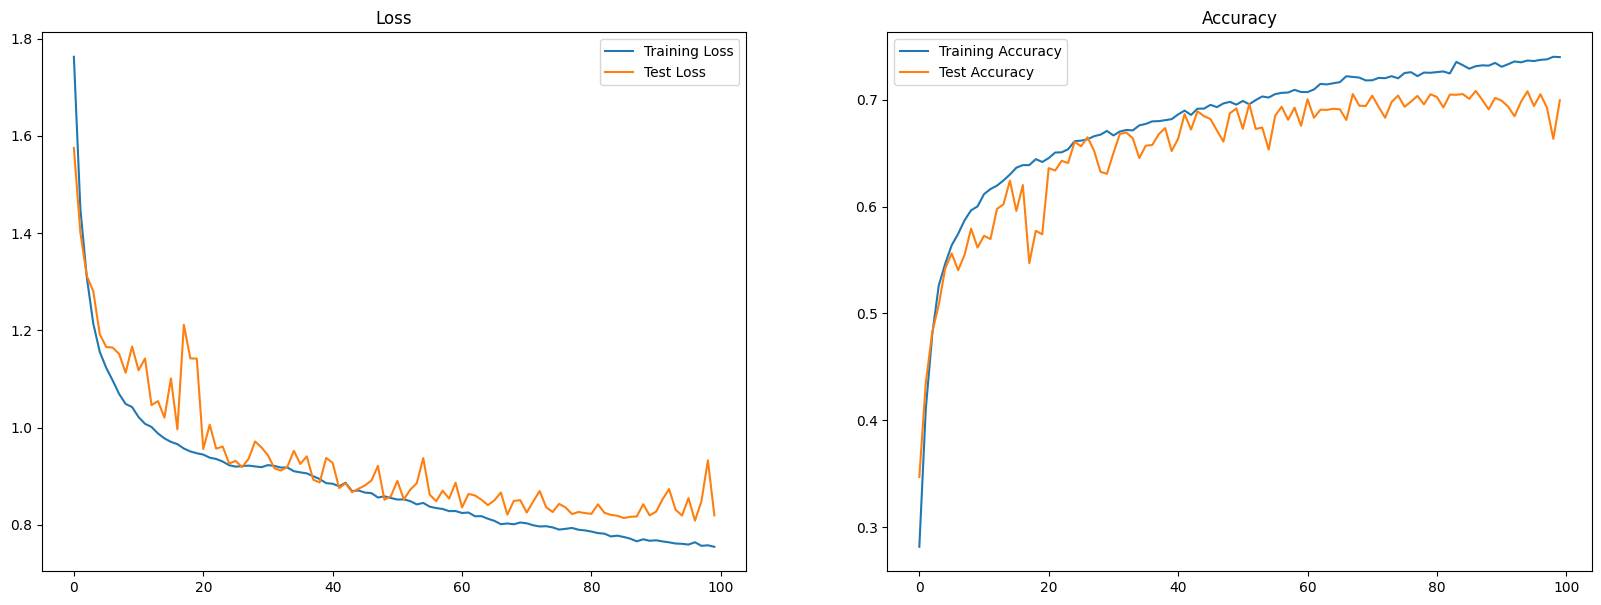

In [9]:
plots=[(train_losses,test_losses),(train_accuracies,test_accuracies)]
plt_labels=[("Training Loss","Test Loss"),("Training Accuracy","Test Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [10]:
# Selecting the best model
best_acc = max(test_accuracies)
best_epoch = test_accuracies.index(best_acc)+1

print("Best accuracy on test set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Model_y/FER_model_{best_epoch}.pth","rb") as f:
    best_model=pickle.load(f)

Best accuracy on test set: 70.82%
Best epoch: 87


## Recalculate the test loss and accuracy

In [11]:
model = best_model
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

In [12]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

Test Loss: 0.0127903230715163
Test Accuracy on the 5813 test images: 69.99827971787373%
